## Bike crashes and bike trips

Here I analyze the frequency of bike crashes and the frequency of bike trips between citibike stations. The goal is to categorize trips as safe vs. dangerous. This notebook provides some initial visualizations.

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from matplotlib import cm
#import os
#os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

In [4]:
#Import and set up some mapping utilities
from mpl_toolkits.basemap import Basemap
import tilemapbase
tilemapbase.start_logging()
extent = tilemapbase.Extent.from_lonlat(-74.03,-73.91, 40.65, 40.81)
t = tilemapbase.tiles.Carto_Light

In [8]:
#Load crash dataset and get bike incidents
crash_df = pd.read_csv('../../data/NYC/NYPD_Motor_Vehicle_Collisions.csv')
bool_2018 = crash_df['DATE'].map(lambda x: (int(x[-4:]) < 2019) and (int(x[-4:]) > 2017))
bike_bool = (crash_df['VEHICLE TYPE CODE 1'] == 'Bike') | (crash_df['VEHICLE TYPE CODE 2'] == 'Bike') | (crash_df['VEHICLE TYPE CODE 3'] == 'Bike') | (crash_df['VEHICLE TYPE CODE 4'] == 'Bike') | (crash_df['VEHICLE TYPE CODE 5'] == 'Bike')
lon_bool = (crash_df['LONGITUDE'] < -73.91)&(crash_df['LONGITUDE'] > -74.03)
lat_bool = (crash_df['LATITUDE']>40.5) & (crash_df['LATITUDE'] < 40.81)

bike_crashes_2018_df= crash_df[bike_bool & bool_2018 & lon_bool & lat_bool]
bike_crashes_2018_df.head()

DATE   TIME    BOROUGH ZIP CODE   LATITUDE  LONGITUDE  \
67414  12/31/2018  17:30        NaN      NaN  40.669777 -73.958300   
67443  12/31/2018  18:05        NaN      NaN  40.703370 -73.937650   
67553  12/31/2018  20:00   BROOKLYN    11228  40.628204 -74.012860   
67648  12/31/2018  22:30  MANHATTAN    10022  40.755350 -73.969670   
67858  12/30/2018  13:00   BROOKLYN    11210  40.637917 -73.953094   

                      LOCATION                    ON STREET NAME  \
67414    (40.669777, -73.9583)  FRANKLIN AVENUE                    
67443    (40.70337, -73.93765)  BUSHWICK AVENUE                    
67553   (40.628204, -74.01286)  FORT HAMILTON PARKWAY              
67648    (40.75535, -73.96967)                               NaN   
67858  (40.637917, -73.953094)                               NaN   

      CROSS STREET NAME                           OFF STREET NAME  \
67414               NaN                                       NaN   
67443               NaN                                       NaN   
67553         70 STREET                                       NaN   
67648               NaN  248       EAST 50 STREET                   
67858               NaN  1332      FLATBUSH AVENUE                  

              ...          CONTRIBUTING FACTOR VEHICLE 2  \
67414         ...                            Unspecified   
67443         ...                                    NaN   
67553         ...                            Unspecified   
67648         ...                   Unsafe Lane Changing   
67858         ...                            Unspecified   

       CONTRIBUTING FACTOR VEHICLE 3  CONTRIBUTING FACTOR VEHICLE 4  \
67414                            NaN                            NaN   
67443                            NaN                            NaN   
67553                            NaN                            NaN   
67648                            NaN                            NaN   
67858                    Unspecified                            NaN   

       CONTRIBUTING FACTOR VEHICLE 5  UNIQUE KEY  VEHICLE TYPE CODE 1  \
67414                            NaN     4055604                Sedan   
67443                            NaN     4055432                 Bike   
67553                            NaN     4061335                Sedan   
67648                            NaN     4055684                 Taxi   
67858                            NaN     4055242                 Bike   

                       VEHICLE TYPE CODE 2  \
67414                                 Bike   
67443                                  NaN   
67553                                 Bike   
67648                                 Bike   
67858  Station Wagon/Sport Utility Vehicle   

                       VEHICLE TYPE CODE 3 VEHICLE TYPE CODE 4  \
67414                                  NaN                 NaN   
67443                                  NaN                 NaN   
67553                                  NaN                 NaN   
67648                                  NaN                 NaN   
67858  Station Wagon/Sport Utility Vehicle                 NaN   

      VEHICLE TYPE CODE 5  
67414                 NaN  
67443                 NaN  
67553                 NaN  
67648                 NaN  
67858                 NaN  

[5 rows x 29 columns]

In [9]:
bike_crash_latlon_df = bike_crashes_2018_df[['LATITUDE','LONGITUDE']]

In [10]:
### Upload cleaned bike trip dataframe and stations dataframe
subs_df = pd.read_pickle('../../data/pickledDFs/subs_df-NYC_Summer_2018.pkl')
stations_info_df = pd.read_pickle('../../data/pickledDFs/stations_info_df-NYC_Summer_2018.pkl')
subs_trips_df = pd.read_pickle('../../data/pickledDFs/subs_trips_df-NYC_Summer_2018.pkl')
###

In [48]:
#Count total trips between stations
trip_counts_df = subs_trips_df.groupby('start_end_station').count()['tripduration'].rename('trip_counts')

In [49]:
trip_counts_df.head()

start_end_station
(72, 72)     219
(72, 79)      50
(72, 82)       1
(72, 127)    137
(72, 128)     74
Name: trip_counts, dtype: int64

In [50]:
stations_info_df.head()

lat        lon                   station name
72   40.767272 -73.993929               W 52 St & 11 Ave
79   40.719116 -74.006667       Franklin St & W Broadway
82   40.711174 -74.000165         St James Pl & Pearl St
83   40.683826 -73.976323  Atlantic Ave & Fort Greene Pl
119  40.696089 -73.978034       Park Ave & St Edwards St

In [53]:
#Create trip_count dataframe and add max/min lat/lon columns
trip_counts_df = pd.DataFrame(trip_counts_df)
trip_counts_df['max_lat'] = trip_counts_df.index.map(lambda a: max(stations_info_df.loc[a[0],'lat'],stations_info_df.loc[a[1],'lat'])).values
trip_counts_df['min_lat'] = trip_counts_df.index.map(lambda a: min(stations_info_df.loc[a[0],'lat'],stations_info_df.loc[a[1],'lat'])).values
trip_counts_df['max_lon'] = trip_counts_df.index.map(lambda a: max(stations_info_df.loc[a[0],'lon'],stations_info_df.loc[a[1],'lon'])).values
trip_counts_df['min_lon'] = trip_counts_df.index.map(lambda a: min(stations_info_df.loc[a[0],'lon'],stations_info_df.loc[a[1],'lon'])).values

In [54]:
trip_counts_df.head()

trip_counts    max_lat    min_lat    max_lon    min_lon
start_end_station                                                         
(72, 72)                   219  40.767272  40.767272 -73.993929 -73.993929
(72, 79)                    50  40.767272  40.719116 -73.993929 -74.006667
(72, 82)                     1  40.767272  40.711174 -73.993929 -74.000165
(72, 127)                  137  40.767272  40.731724 -73.993929 -74.006744
(72, 128)                   74  40.767272  40.727103 -73.993929 -74.002971

In [68]:
#Count number of crashes within each station-station box
trip_counts_df['tot_crashes'] = 0

for crash in bike_crashes_2018_df.index:
    lat = bike_crashes_2018_df.loc[crash,'LATITUDE']
    lon = bike_crashes_2018_df.loc[crash,'LONGITUDE']
    min_latbool = trip_counts_df['min_lat'] < lat
    max_latbool = trip_counts_df['max_lat'] > lat
    min_lonbool = trip_counts_df['min_lon'] < lon
    max_lonbool = trip_counts_df['max_lon'] > lon
    trip_counts_df.loc[min_latbool & max_latbool & min_lonbool & max_lonbool,'tot_crashes'] += 1

In [96]:
#Create some normalized measures of crashes per station-station trip

#Crashes divided by box area
trip_counts_df['area'] = (trip_counts_df['max_lat'] - trip_counts_df['min_lat'])*(trip_counts_df['max_lon'] - trip_counts_df['min_lon'])
trip_counts_df = trip_counts_df[trip_counts_df['area'] != 0.0] #Remove single station trips
trip_counts_df['crashes_per_area'] = trip_counts_df['tot_crashes']/trip_counts_df['area']

#Crashes divided by station separation
trip_counts_df['distance'] = np.sqrt((trip_counts_df['max_lat'] - trip_counts_df['min_lat'])**2 + (trip_counts_df['max_lon'] - trip_counts_df['min_lon'])**2)
trip_counts_df['crashes_per_distance'] = trip_counts_df['tot_crashes']/trip_counts_df['distance']

In [115]:
#Define some sorted dataframes
top_by_crashes_per_distance = trip_counts_df.sort_values('crashes_per_distance',ascending = False)
top_by_crashes_per_area = trip_counts_df.sort_values('crashes_per_area',ascending = False)
top_crashes = trip_counts_df.sort_values('tot_crashes',ascending=False)

In [100]:
trip_counts_df.describe()['area']

count    1.514250e+05
mean     6.725578e-04
std      8.120272e-04
min      9.349928e-10
25%      1.156035e-04
50%      3.685815e-04
75%      9.399230e-04
max      1.049828e-02
Name: area, dtype: float64

In [107]:
#Compute projected coordinates of crashes and stations

#Bike crash locations
lat_lon_df = bike_crashes_2018_df[['LONGITUDE','LATITUDE']].dropna()
x = lat_lon_df['LONGITUDE'];
y = lat_lon_df['LATITUDE'];
crashes = [tilemapbase.project(x,y) for x,y in zip(lat_lon_df['LONGITUDE'], lat_lon_df['LATITUDE'])]
x, y = zip(*crashes)

#Station locations
stations = [tilemapbase.project(x,y) for x,y in zip(stations_info_df['lon'], stations_info_df['lat'])]
stat_x, stat_y  = zip(*stations)
stations_info_df['proj_x'] = stat_x 
stations_info_df['proj_y'] = stat_y


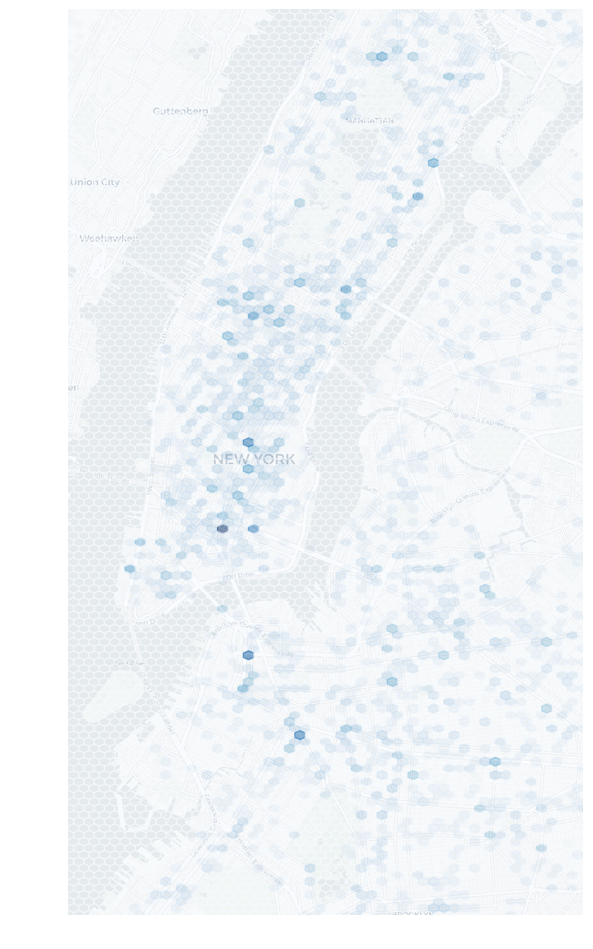

In [214]:
#Hexbin plot of bike crashes
fig, ax = plt.subplots(figsize=(12,12), dpi=100)

ax.set_axis_off()

ax.hexbin(x, y, gridsize=(50, 100), cmap=plt.cm.Blues, alpha = .5);

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

In [210]:
#Find most frequent trips and plot those
top_1000_trips_df = trip_counts_df.sort_values('trip_counts',ascending=False)[:1000]
top_1000_trips_df.head()
top_1000_trips_df['area'].describe()

count    1.000000e+03
mean     4.596458e-05
std      1.126523e-04
min      3.292950e-09
25%      1.010477e-05
50%      2.316099e-05
75%      4.797584e-05
max      2.338526e-03
Name: area, dtype: float64

In [223]:
#Throw away small area trips, keep largest half
top_500_drop_smallestA = top_1000_trips_df[top_1000_trips_df['area'] > top_1000_trips_df['area'].quantile(q=.5)]

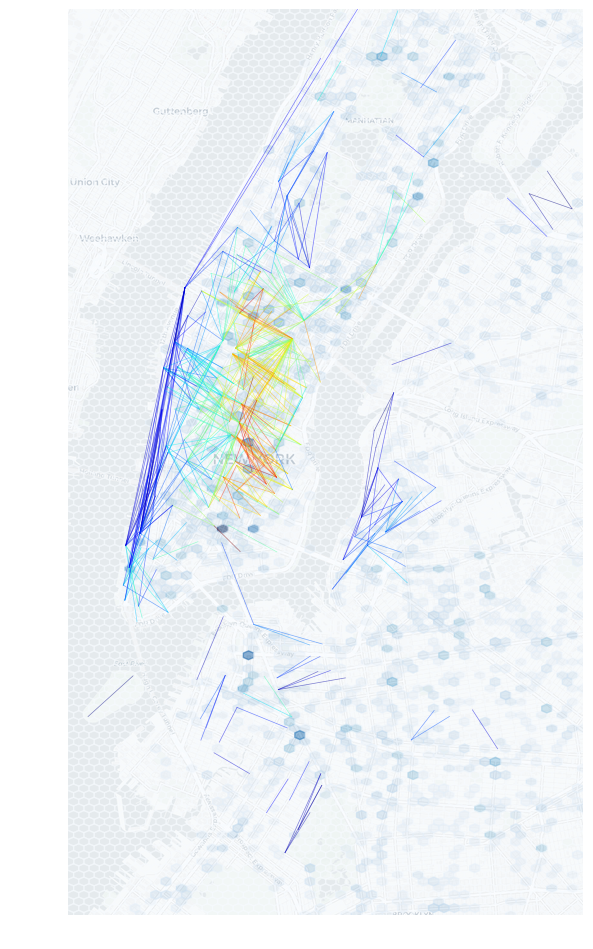

In [227]:
#Plot of most frequent trips, with color determined by number of crashes per area
fig, ax = plt.subplots(figsize=(12,12), dpi=100)

ax.set_axis_off()

ax.hexbin(x, y, gridsize=(50, 100), cmap=plt.cm.Blues, alpha = .5);

cmap = cm.get_cmap('jet')

max_crashes = top_500_drop_smallestA['crashes_per_area'].max()
min_crashes = top_500_drop_smallestA['crashes_per_area'].min()

for num in range(len(top_500_drop_smallestA.index)):
    
    stat_tuple = top_500_drop_smallestA.index[num]
    stat1 = stat_tuple[0]
    stat2 = stat_tuple[1]
    
    startlat = stations_info_df.loc[stat1]['proj_y']
    endlat = stations_info_df.loc[stat2]['proj_y']
    lats = [startlat, endlat]
    
    startlon = stations_info_df.loc[stat1]['proj_x']
    endlon = stations_info_df.loc[stat2]['proj_x']
    lons = [startlon,endlon]
    
    ax.plot(lons, lats,color=cmap((top_500_drop_smallestA.iloc[num]['crashes_per_area']-min_crashes)/(max_crashes-min_crashes)),linewidth = .5,alpha=.5)


plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

The rest of the images are examples of what not to do

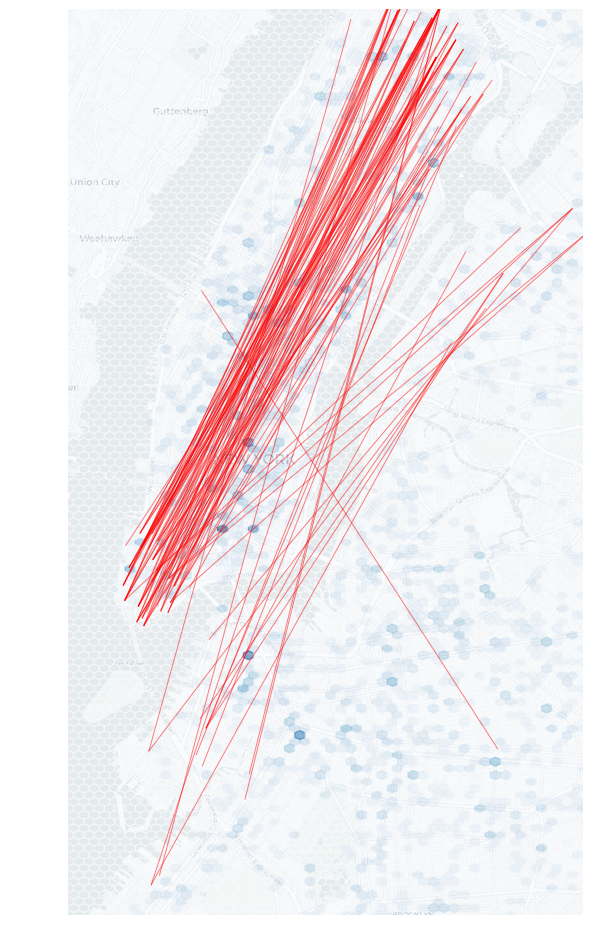

In [220]:
#Plot trips with most total crashes (dominated by largest areas)
fig, ax = plt.subplots(figsize=(12,12), dpi=100)

ax.set_axis_off()

ax.hexbin(x, y, gridsize=(50, 100), cmap=plt.cm.Blues, alpha = .5);

for item in top_crashes.index[:100]:
    
    startlat = stations_info_df.loc[item[0]]['proj_y']
    endlat = stations_info_df.loc[item[1]]['proj_y']
    lats = [startlat, endlat]
    
    startlon = stations_info_df.loc[item[0]]['proj_x']
    endlon = stations_info_df.loc[item[1]]['proj_x']
    lons = [startlon,endlon]
    
    ax.plot(lons, lats,color='r',linewidth = .7,alpha=.5)


plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

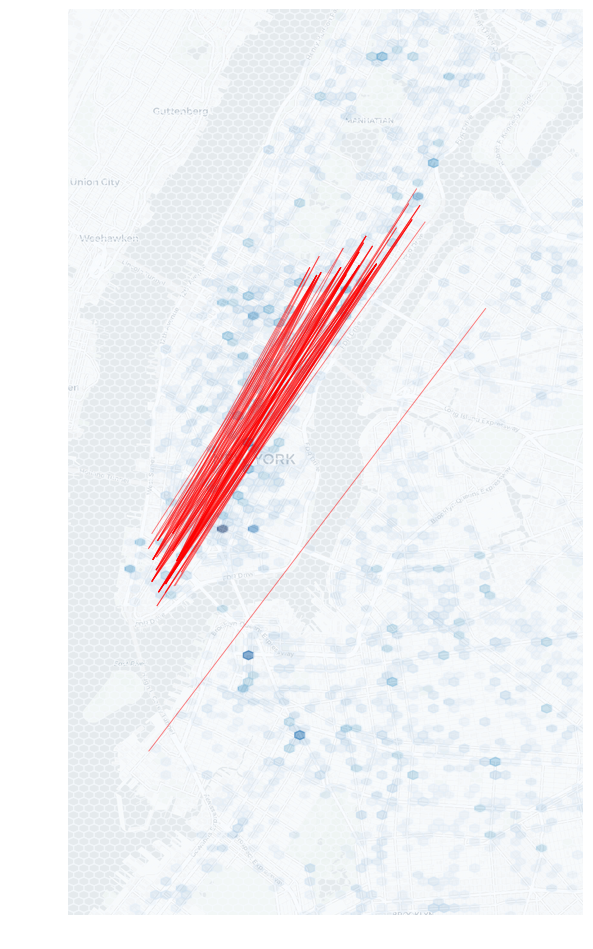

In [218]:
#Plot trips with most crashes divided by station separation
fig, ax = plt.subplots(figsize=(12,12), dpi=100)

ax.set_axis_off()

ax.hexbin(x, y, gridsize=(50, 100), cmap=plt.cm.Blues, alpha = .5);

for item in top_by_crashes_per_distance.index[:100]:
    
    startlat = stations_info_df.loc[item[0]]['proj_y']
    endlat = stations_info_df.loc[item[1]]['proj_y']
    lats = [startlat, endlat]
    
    startlon = stations_info_df.loc[item[0]]['proj_x']
    endlon = stations_info_df.loc[item[1]]['proj_x']
    lons = [startlon,endlon]
    
    ax.plot(lons, lats,color='r',linewidth = .7,alpha=.5)


plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

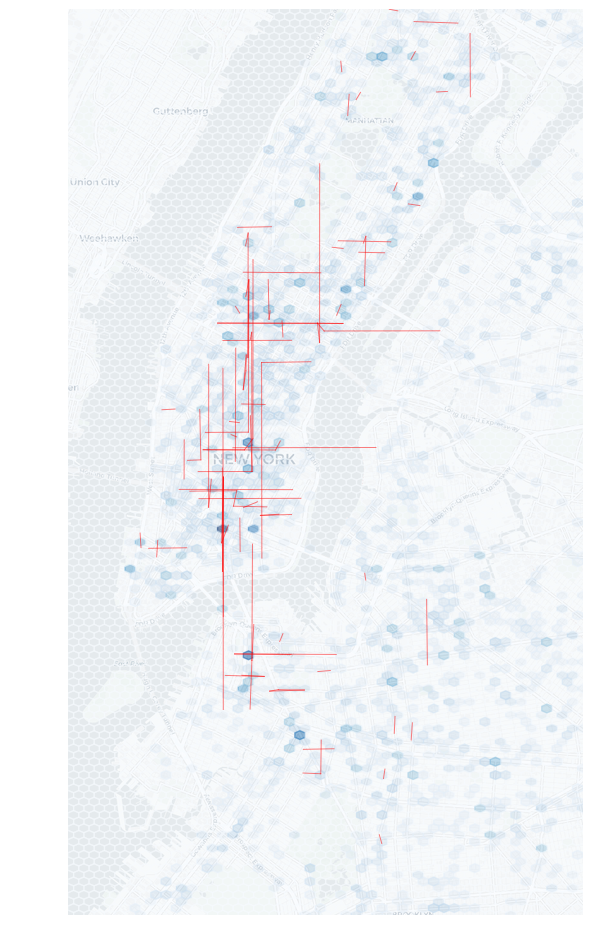

In [217]:
#Try plotting trips with most crashes divided by area (dominated by very small areas)
fig, ax = plt.subplots(figsize=(12,12), dpi=100)

ax.set_axis_off()

ax.hexbin(x, y, gridsize=(50, 100), cmap=plt.cm.Blues, alpha = .5);

for item in top_by_crashes_per_area.index[:100]:
    
    startlat = stations_info_df.loc[item[0]]['proj_y']
    endlat = stations_info_df.loc[item[1]]['proj_y']
    lats = [startlat, endlat]
    
    startlon = stations_info_df.loc[item[0]]['proj_x']
    endlon = stations_info_df.loc[item[1]]['proj_x']
    lons = [startlon,endlon]
    
    ax.plot(lons, lats,color='r',linewidth = .7,alpha=.5)


plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)